# Jonathan Halverson
# Friday, April 8, 2016
# Titanic from Kaggle

Below is a description of the data which consists of the passenger manifest for the ill-fated Titanic ocean liner which met its demise on April 15, 1912:

VARIABLE DESCRIPTIONS:<br>
survival        Survival (0 = No; 1 = Yes)<br>
pclass          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
name            Name<br>
sex             Sex<br>
age             Age<br>
sibsp           Number of Siblings/Spouses Aboard<br>
parch           Number of Parents/Children Aboard<br>
ticket          Ticket Number<br>
fare            Passenger Fare<br>
cabin           Cabin<br>
embarked        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)<br>

SPECIAL NOTES:<br>
Pclass is a proxy for socio-economic status (SES)<br>
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower<br>

Age is in Years; Fractional if Age less than One (1)<br>
 If the Age is Estimated, it is in the form xx.5<br>

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic<br>
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)<br>
Parent:   Mother or Father of Passenger Aboard Titanic<br>
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic<br>

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

Read in the training data and display the first five lines:

In [2]:
df = pd.read_csv('titanic_train.csv', header=0)
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We see from the info command that columns Age, Cabin and Embarked have null values. Below we count these values:

In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.describe().applymap(lambda x: round(x, 2))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.13,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


In [6]:
# How many males and females are in each passenger class
for i in range(1, 4):
    male_age = df[(df.Sex == 'male') & (df.Pclass == i)]['Age']
    print "Class", i, "has", len(male_age), "males with average age of", round(male_age.mean(), 1)
for i in range(1, 4):
    female_age = df[(df.Sex == 'female') & (df.Pclass == i)]['Age']
    print "Class", i, "has", len(female_age), "females with average age of", round(female_age.mean(), 1)

Class 1 has 122 males with average age of 41.3
Class 2 has 108 males with average age of 30.7
Class 3 has 347 males with average age of 26.5
Class 1 has 94 females with average age of 34.6
Class 2 has 76 females with average age of 28.7
Class 3 has 144 females with average age of 21.8


### Data cleaning

We need to convert Sex and Embarked to numerical values. The Name column will be ignored. Before we do that we must fill in the missing Age values. We will use the median values within each gender for a given class using the combined train and test data:

In [7]:
df_test = pd.read_csv('titanic_test.csv', header=0)
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
df_train_test = pd.concat([df, df_test], ignore_index=True)
df_train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


There were thought to be 1317 passengers on board the ship so it appears that some data is missing.

Create an encoder to convert Sex to integers. The encoder will be used for the rest of the notebook to ensure consistency.

In [9]:
from sklearn import preprocessing
sex_encoder = preprocessing.LabelEncoder()
df_train_test['Sex'] = sex_encoder.fit_transform(df_train_test['Sex'])

Compute the median ages for a given gender within each passenger class:

In [10]:
median_ages = np.zeros((2, 3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i, j] = df_train_test[(df_train_test.Sex == i) & (df_train_test.Pclass == j + 1)]['Age'].dropna().median()
print median_ages

[[ 36.   28.   22. ]
 [ 42.   29.5  25. ]]


In [11]:
def load_feature_matrix(filename, gender_encoder, median_age_matrix):
    """This method applies the same cleaning operations to the train and test data."""
    df = pd.read_csv(filename, header=0)
    df['Sex'] = gender_encoder.transform(df['Sex'])
    df['AgeFill'] = df['Age']
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[(df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j + 1), 'AgeFill'] = median_age_matrix[i, j]
    # drop columns composed of strings like Embarked, Name, Cabin
    drop_cols = [c for c, t in zip(df.columns, df.dtypes) if t == 'object']
    df = df.drop(labels=drop_cols, axis=1)
    return df

In [12]:
df = load_feature_matrix('titanic_train.csv', sex_encoder, median_ages)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,AgeFill
0,1,0,3,1,22.0,1,0,7.2500,22.0
1,2,1,1,0,38.0,1,0,71.2833,38.0
2,3,1,3,0,26.0,0,0,7.9250,26.0
3,4,1,1,0,35.0,1,0,53.1000,35.0
4,5,0,3,1,35.0,0,0,8.0500,35.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
AgeFill        891 non-null float64
dtypes: float64(3), int64(6)
memory usage: 62.7 KB


### Visualization of the data towards feature engineering

Let's look at the correlation matrix before making figures:

In [14]:
df.corr().applymap(lambda x: round(x, 2))

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,AgeFill
PassengerId,1.00,-0.01,-0.04,0.04,0.04,-0.06,-0.00,0.01,0.04
Survived,-0.01,1.00,-0.34,-0.54,-0.08,-0.04,0.08,0.26,-0.06
Pclass,-0.04,-0.34,1.00,0.13,-0.37,0.08,0.02,-0.55,-0.42
Sex,0.04,-0.54,0.13,1.00,0.09,-0.11,-0.25,-0.18,0.10
Age,0.04,-0.08,-0.37,0.09,1.00,-0.31,-0.19,0.10,1.00
SibSp,-0.06,-0.04,0.08,-0.11,-0.31,1.00,0.41,0.16,-0.25
Parch,-0.00,0.08,0.02,-0.25,-0.19,0.41,1.00,0.22,-0.18
Fare,0.01,0.26,-0.55,-0.18,0.10,0.16,0.22,1.00,0.12
AgeFill,0.04,-0.06,-0.42,0.10,1.00,-0.25,-0.18,0.12,1.00


The correlation matrix shows that the outcome Survived is most strongly correlated with Pclass, Sex and Fare. Fare and Pclass are moderately collinear and are thought to contain essentially the same information.

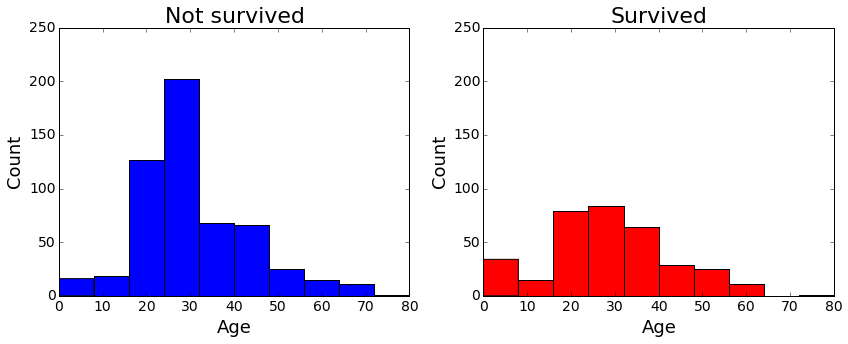

In [15]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax0.hist(df[df.Survived == 0].AgeFill.values, bins=10, range=(0, 80))
ax1.hist(df[df.Survived == 1].AgeFill.values, bins=10, range=(0, 80), color='r')
for ax in fig.axes:
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 250)
    ax.set_xlabel('Age')
    ax.set_ylabel('Count')
ax0.set_title('Not survived')
ax1.set_title('Survived')
plt.tight_layout()

Below is a breakdown of the figure above by class:

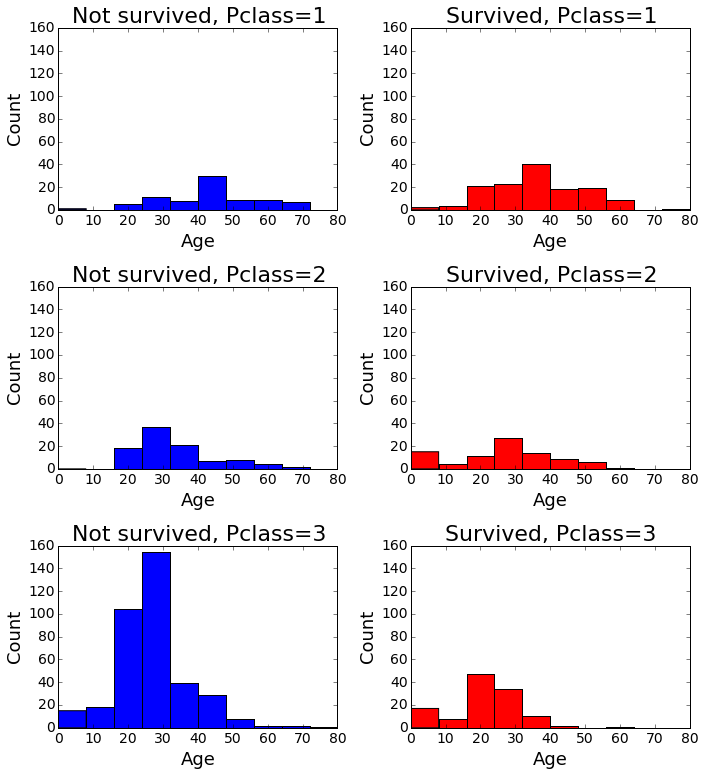

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 11))
ax[0][0].hist(df[(df.Survived == 0) & (df.Pclass == 1)].AgeFill.values, bins=10, range=(0, 80))
ax[0][1].hist(df[(df.Survived == 1) & (df.Pclass == 1)].AgeFill.values, bins=10, range=(0, 80), color='r')
ax[1][0].hist(df[(df.Survived == 0) & (df.Pclass == 2)].AgeFill.values, bins=10, range=(0, 80))
ax[1][1].hist(df[(df.Survived == 1) & (df.Pclass == 2)].AgeFill.values, bins=10, range=(0, 80), color='r')
ax[2][0].hist(df[(df.Survived == 0) & (df.Pclass == 3)].AgeFill.values, bins=10, range=(0, 80))
ax[2][1].hist(df[(df.Survived == 1) & (df.Pclass == 3)].AgeFill.values, bins=10, range=(0, 80), color='r')
for i in range(3):
    ax[i][0].set_title('Not survived, Pclass=' + str(i+1))
    ax[i][1].set_title('Survived, Pclass=' + str(i+1))
for ax in fig.axes:
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 160)
    ax.set_xlabel('Age')
    ax.set_ylabel('Count')
plt.tight_layout()

The figure above shows that people with a range of ages died within each class.

###### Who fared better, women over age 18 or children?

In [17]:
female_adults = df[(df.AgeFill >= 18) & (df.Sex == 0)]
print len(female_adults[female_adults.Survived == 1]) / float(len(female_adults))

0.752895752896


In [18]:
children = df[(df.AgeFill < 18)]
print len(children[children.Survived == 1]) / float(len(children))

0.53982300885


We see that 54.0% of the children survived while 75.3% of the women aged 18 or older survived.

### Contingency tables

In [19]:
my_tab = pd.crosstab(index=df["Survived"], columns="count")
my_tab

col_0,count
Survived,
0,549
1,342


In [20]:
survived_sex = pd.crosstab(index=df["Survived"], columns=df["Sex"], margins=True)
survived_sex.index = ["died", "survived", "coltotal"]
survived_sex.columns = ["female", "male", "rowtotal"]
survived_sex

,female,male,rowtotal
died,81,468,549
survived,233,109,342
coltotal,314,577,891


In [21]:
survived_sex / survived_sex.ix["coltotal", "rowtotal"]

,female,male,rowtotal
died,0.090909,0.525253,0.616162
survived,0.261504,0.122334,0.383838
coltotal,0.352413,0.647587,1.000000


The table above gives the proportional within each group out of the entire set of passengers. For instance, 26.2% of all the passengers were women who survived.

In [22]:
survived_sex / survived_sex.loc["coltotal"]

,female,male,rowtotal
died,0.257962,0.811092,0.616162
survived,0.742038,0.188908,0.383838
coltotal,1.000000,1.000000,1.000000


74% of the women survived while 81% of the mean died.

In [23]:
survived_class = pd.crosstab(index=df["Survived"], columns=df["Pclass"], margins=True)
survived_class.index = ["died", "survived", "coltotal"]
survived_class.columns = ["class 1", "class 2", "class 3", "rowtotal"]
survived_class

,class 1,class 2,class 3,rowtotal
died,80,97,372,549
survived,136,87,119,342
coltotal,216,184,491,891


In [24]:
survived_class / survived_class.ix["coltotal","rowtotal"]

,class 1,class 2,class 3,rowtotal
died,0.089787,0.108866,0.417508,0.616162
survived,0.152637,0.097643,0.133558,0.383838
coltotal,0.242424,0.206510,0.551066,1.000000


In [25]:
survival_by_class = survived_class / survived_class.ix["coltotal"]
survival_by_class

,class 1,class 2,class 3,rowtotal
died,0.37037,0.527174,0.757637,0.616162
survived,0.62963,0.472826,0.242363,0.383838
coltotal,1.00000,1.000000,1.000000,1.000000


(0, 1)

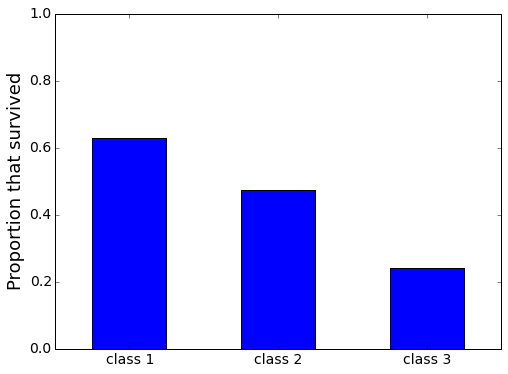

In [26]:
plt.bar([1, 2, 3], survival_by_class.iloc[1,0:3].values, width=0.5, align='center')
plt.xticks([1, 2, 3], survival_by_class.columns[:3])
plt.ylabel("Proportion that survived")
plt.ylim(0, 1)

In [27]:
survived_class.div(survived_class["rowtotal"], axis=0)

,class 1,class 2,class 3,rowtotal
died,0.145719,0.176685,0.677596,1.0
survived,0.397661,0.254386,0.347953,1.0
coltotal,0.242424,0.206510,0.551066,1.0


In [28]:
surv_sex_class = pd.crosstab(index=df["Survived"], columns=[df["Pclass"], df["Sex"]], margins=True)
surv_sex_class

Pclass     1        2         3       All
Sex        0    1   0    1    0    1     
Survived                                 
0          3   77   6   91   72  300  549
1         91   45  70   17   72   47  342
All       94  122  76  108  144  347  891

In [29]:
(surv_sex_class / float(len(df))).applymap(lambda x: round(x, 3))

Pclass        1             2             3           All
Sex           0      1      0      1      0      1       
Survived                                                 
0         0.003  0.086  0.007  0.102  0.081  0.337  0.616
1         0.102  0.051  0.079  0.019  0.081  0.053  0.384
All       0.105  0.137  0.085  0.121  0.162  0.389  1.000

34% of the total passengers were men in third class who died. 10% of all passengers were women in first class who survived.

In [30]:
surv_sex_class[2]

Sex,0,1
Survived,,
0,6,91
1,70,17
All,76,108


In [31]:
(surv_sex_class / surv_sex_class.ix["All"]).applymap(lambda x: round(x, 2))

Pclass       1           2          3         All
Sex          0     1     0     1    0     1      
Survived                                         
0         0.03  0.63  0.08  0.84  0.5  0.86  0.62
1         0.97  0.37  0.92  0.16  0.5  0.14  0.38
All       1.00  1.00  1.00  1.00  1.0  1.00  1.00

### Feature engineering

Having examine the various contingency tables and figures above. Let's try to introduce some new features that will aid our predictions. Despite having a few feature that are correlated with the outcome, let's add two new features:

In [32]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df['Age*Class'] = df.AgeFill * df.Pclass

### Classifier

Now that the data is clean and we have an understanding of the important features, we can build a classifier:

In [48]:
from sklearn.metrics import log_loss, accuracy_score
def get_score(train, test, model, columns):
    model.fit(X=np.asarray(train[columns].values), y=np.asarray(train.Survived.values))
    predictions = model.predict_proba(np.asarray(test[columns]))[:,1]
    return log_loss(test.Survived.values, predictions), accuracy_score(test.Survived.values, model.predict(np.asarray(test[columns])))

We can easily try different feature sets using the function above which returns the logloss and accuracy.

In [55]:
X_train = df.ix[:600]
X_test = df.ix[600:]

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')

In [56]:
print get_score(X_train, X_test, rf, ['Pclass'])

(0.57824612959803345, 0.69759450171821302)


In [57]:
print get_score(X_train, X_test, rf, ['Pclass', 'Sex'])

(0.44013580632487009, 0.7766323024054983)


In [58]:
print get_score(X_train, X_test, rf, ['Pclass', 'Sex', 'AgeFill'])

(0.64392376315304678, 0.80412371134020622)


In [53]:
print get_score(X_train, X_test, rf, ['Pclass', 'Sex', 'AgeFill', 'Age*Class'])

(1.0039643629498782, 0.81443298969072164)


In [54]:
print get_score(X_train, X_test, rf, ['Pclass', 'Sex', 'AgeFill', 'FamilySize'])

(0.98608582789792698, 0.80412371134020622)


Uses three or four of the key features we obtained an accuracy around 80%.